In [92]:
import torch
from imagen_pytorch import Unet, Imagen, ImagenTrainer
from torchvision import transforms
from imagen_pytorch.data import Dataset
from PIL import Image
import os
from download_dataset import download_dataset
from transformers import BlipProcessor, BlipForConditionalGeneration
import json
from transformers import T5Tokenizer, T5EncoderModel

In [72]:
image_size = 256 # Target size for the second U-Net
transform = transforms.Compose([
    transforms.Resize(image_size),       # Resize smaller edge to image_size
    transforms.CenterCrop(image_size),   # Crop center to image_size x image_size
    transforms.ToTensor(),               # Convert PIL image [0, 255] to tensor [0, 1]
    # Optional: Add normalization if required by the model, e.g., for [-1, 1] range
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class ImageDataset(Dataset):
    def __init__(self, root_dir, text_embeds, transform=None):
        self.root_dir = root_dir
        self.files = [os.path.join(root_dir, file) for file in os.listdir(root_dir) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.text_embeds = text_embeds
        self.transform = transform

        assert len(self.files) == len(self.text_embeds), "Number of images is different from number of text encodings"

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f'Error loading image {img_path}: {e}')
            return None, None
        
        text_embedding = self.text_embeds[idx]

        if self.transform:
            image_t = self.transform(image)
        return image_t, text_embedding

In [ ]:
source_directory = 'datasets/dimensi0n/imagenet-256/zebra'
captions_creating_batch_size = 8
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# --- List Image Files ---
# Ensure consistent order by sorting
image_files = sorted([
    os.path.join(source_directory, f)
    for f in os.listdir(source_directory)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])
print(f"Found {len(image_files)} images in {source_directory}")

# --- Generate Captions ---
captions_data = [] # List to store {'image_path'
model.eval() # Set model to evaluation mode

with torch.no_grad(): # Disable gradient calculation for inference
    for i in range(0, len(image_files), captions_creating_batch_size):
        batch_files = image_files[i:i+captions_creating_batch_size]
        raw_images = []
        valid_files_in_batch = [] # Keep track of files successfully loaded in this batch

        # Load images in the batch
        for img_path in batch_files:
            try:
                image = Image.open(img_path).convert('RGB')
                raw_images.append(image)
                valid_files_in_batch.append(img_path)
            except Exception as e:
                print(f"Warning: Could not load image {img_path}. Skipping. Error: {e}")

        if not raw_images: # Skip if no images were loaded in the batch
            print(f"Skipping empty batch starting at index {i}")
            continue

        # Preprocess images
        inputs = processor(images=raw_images, return_tensors="pt").to(device)

        # Generate captions
        # You can adjust generation parameters like max_length, num_beams, etc.
        outputs = model.generate(**inputs, max_length=75, num_beams=4) # Increased max_length slightly

        # Decode captions
        decoded_captions = processor.batch_decode(outputs, skip_special_tokens=True)

        # Store results for this batch
        for img_path, caption in zip(valid_files_in_batch, decoded_captions):
            captions_data.append({'image_path': img_path, 'caption': caption.strip()})

        print(f"Processed batch {i//captions_creating_batch_size + 1}/{(len(image_files) + captions_creating_batch_size - 1)//captions_creating_batch_size}, Captions generated: {len(captions_data)}")


# --- Save Captions ---
try:
    with open(os.path.join(source_directory, 'captions.json'), 'w') as f:
        json.dump(captions_data, f, indent=4)
    print("Captions saved successfully.")
except Exception as e:
    print(f"Error saving captions: {e}")

Using device: cuda
Found 632 images in datasets/dimensi0n/imagenet-256/zebra
Processed batch 1/79, Captions generated: 8
Processed batch 2/79, Captions generated: 16
Processed batch 3/79, Captions generated: 24
Processed batch 4/79, Captions generated: 32
Processed batch 5/79, Captions generated: 40
Processed batch 6/79, Captions generated: 48
Processed batch 7/79, Captions generated: 56
Processed batch 8/79, Captions generated: 64
Processed batch 9/79, Captions generated: 72
Processed batch 10/79, Captions generated: 80
Processed batch 11/79, Captions generated: 88
Processed batch 12/79, Captions generated: 96
Processed batch 13/79, Captions generated: 104
Processed batch 14/79, Captions generated: 112
Processed batch 15/79, Captions generated: 120
Processed batch 16/79, Captions generated: 128
Processed batch 17/79, Captions generated: 136
Processed batch 18/79, Captions generated: 144
Processed batch 19/79, Captions generated: 152
Processed batch 20/79, Captions generated: 160
Proce

In [70]:
source_directory = 'datasets/dimensi0n/imagenet-256/zebra'
with open(os.path.join(source_directory, 'captions.json'), 'r') as f:
    captions_data = json.load(f)

image_files = sorted([
    os.path.join(source_directory, f)
    for f in os.listdir(source_directory)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])

captions = [image['caption'] for image in captions_data if image['image_path'] in image_files]

t5_model_name = 't5-large'
print(f"Loading T5 Tokenizer and Encoder Model ({t5_model_name})...")
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
t5_model = T5EncoderModel.from_pretrained(t5_model_name).cuda() # Move model to GPU
t5_model.eval() # Set T5 model to evaluation mode
print("T5 models loaded.")

text_encoding_batch_size = 16
max_text_seq_len = 256 
all_text_embeds = []

with torch.no_grad(): # No need to track gradients for encoding
    for i in range(0, len(captions), text_encoding_batch_size):
        batch_texts = captions[i:i+text_encoding_batch_size]
        tokenized_inputs = t5_tokenizer(
            batch_texts,
            padding='max_length',       # Pad to max_length
            truncation=True,            # Truncate sequences longer than max_length
            max_length=max_text_seq_len,# The maximum sequence length
            return_tensors='pt'         # Return PyTorch tensors
        ).to(imagen.device) # Move tokenized inputs to the same device as the T5 model

        # Get embeddings from T5 model
        # T5EncoderModel output is a BaseModelOutput, embeddings are in last_hidden_state
        outputs = t5_model(input_ids=tokenized_inputs.input_ids, attention_mask=tokenized_inputs.attention_mask)
        text_embeds_batch = outputs.last_hidden_state # Shape: [batch_size, max_text_seq_len, 1024]

        # Append to list (move to CPU to save GPU memory during accumulation)
        all_text_embeds.append(text_embeds_batch.cpu())

# Concatenate all embedding batches
text_embeddings_tensor = torch.cat(all_text_embeds, dim=0)
print(f"Generated text embeddings shape: {text_embeddings_tensor.shape}")

Loading T5 Tokenizer and Encoder Model (t5-large)...
T5 models loaded.
Generated text embeddings shape: torch.Size([632, 256, 1024])


In [47]:
sample_embed = imagen.encode_text(captions[:2])
print(sample_embed.shape)

torch.Size([2, 13, 1024])


In [ ]:
from transformers import T5ForConditionalGeneration
from transformers import T5Tokenizer

model = T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizer = T5Tokenizer.from_pretrained('t5-base')
t5_prepared_Text = "summarize: "+"asdasd"
tokenized_text = tokenizer.encode(t5_prepared_Text,  max_length=1024,return_tensors="pt")
imagen.encode_text()
tokenized_text

tensor([[21603,    10,    38,  7664,    26,     1]])

In [50]:
all_text_embeds[7].shape
for embed in all_text_embeds:
    print(embed.shape)

torch.Size([16, 15, 1024])
torch.Size([16, 19, 1024])
torch.Size([16, 18, 1024])
torch.Size([16, 18, 1024])
torch.Size([16, 18, 1024])
torch.Size([16, 20, 1024])
torch.Size([16, 17, 1024])
torch.Size([16, 57, 1024])
torch.Size([16, 18, 1024])
torch.Size([16, 16, 1024])
torch.Size([16, 16, 1024])
torch.Size([16, 21, 1024])
torch.Size([16, 18, 1024])
torch.Size([16, 21, 1024])
torch.Size([16, 18, 1024])
torch.Size([16, 18, 1024])
torch.Size([16, 20, 1024])
torch.Size([16, 17, 1024])
torch.Size([16, 16, 1024])
torch.Size([16, 20, 1024])
torch.Size([16, 20, 1024])
torch.Size([16, 20, 1024])
torch.Size([16, 20, 1024])
torch.Size([16, 17, 1024])
torch.Size([16, 20, 1024])
torch.Size([16, 22, 1024])
torch.Size([16, 18, 1024])
torch.Size([16, 16, 1024])
torch.Size([16, 20, 1024])
torch.Size([16, 18, 1024])
torch.Size([16, 21, 1024])
torch.Size([16, 17, 1024])
torch.Size([16, 18, 1024])
torch.Size([16, 17, 1024])
torch.Size([16, 21, 1024])
torch.Size([16, 20, 1024])
torch.Size([16, 20, 1024])
t

In [96]:
# Imagen Unets

unet1 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = 3,
    layer_attns = (False, True, True, True),
)

unet2 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = (2, 4, 8, 8),
    layer_attns = (False, False, False, True),
    layer_cross_attns = (False, False, False, True)
)

# imagen, which contains the unets above (base unet and super resoluting ones)

imagen = Imagen(
    unets = (unet1, unet2),
    text_encoder_name = 't5-large',
    image_sizes = (64, 256),
    timesteps = 1000,
    cond_drop_prob = 0.1
).cuda()

dataset = ImageDataset(root_dir=source_directory, text_embeds=text_embeddings_tensor, transform=transform)

In [74]:
batch_size = 4

# Handles None returns from failed image loads
def collate_fn(batch):
    batch = list(filter(lambda x: x[0] is not None, batch)) # Filter out samples where image loading failed
    if not batch: return torch.Tensor(), torch.Tensor() # Return empty tensors if batch is empty
    return torch.utils.data.dataloader.default_collate(batch)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn) # num_workers sets parallel data loading threadsz

In [97]:
# wrap imagen with the trainer class

imagen.train()
trainer = ImagenTrainer(imagen).cuda()
trainer.train()

num_epochs = 1
# feed images into imagen, training each unet in the cascade

optimizer = torch.optim.Adam(imagen.parameters(), lr=1e-4) # Example optimizer

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for images_batch, text_embeds_batch in dataloader:
        if images_batch.numel() == 0: continue # Skip if batch is empty after filtering

        images_batch = images_batch.cuda()
        text_embeds_batch = text_embeds_batch.cuda()

        # Ensure batch sizes match if text embeds weren't batched by DataLoader
        # (This shouldn't be needed with the custom dataset structure above)
        # current_batch_size = images_batch.size(0)
        # text_embeds = text_embeds_batch[:current_batch_size] # Adjust if needed

        # feed images into imagen, training each unet in the cascade
        for i in (1, 2): # Train both U-Nets
             # You might need different image sizes/transforms per U-Net
             # For simplicity, using the same batch here. Consider resizing/downsampling
             # images_for_unet = F.interpolate(images_batch, size=imagen.image_sizes[i-1]) if i==1 else images_batch

            optimizer.zero_grad()
            loss = imagen(images_batch, text_embeds = text_embeds_batch, unet_number = i)
            print(f"  Unet {i}, Loss: {loss.item()}") # Optional: print loss
            loss.backward()
            optimizer.step()

Epoch 1/1
  Unet 1, Loss: 0.7786549925804138
  Unet 2, Loss: 1.0016653537750244
  Unet 1, Loss: 0.9585717916488647
  Unet 2, Loss: 0.7962106466293335
  Unet 1, Loss: 1.0017588138580322
  Unet 2, Loss: 1.0000873804092407
  Unet 1, Loss: 0.9831244945526123
  Unet 2, Loss: 0.76459139585495
  Unet 1, Loss: 0.6224967241287231


KeyboardInterrupt: 

In [ ]:
images = imagen.sample(texts = [
    'a whale breaching from afar',
    'young girl blowing out candles on her birthday cake',
    'fireworks with blue and green sparkles'
], cond_scale = 3.)

images.shape

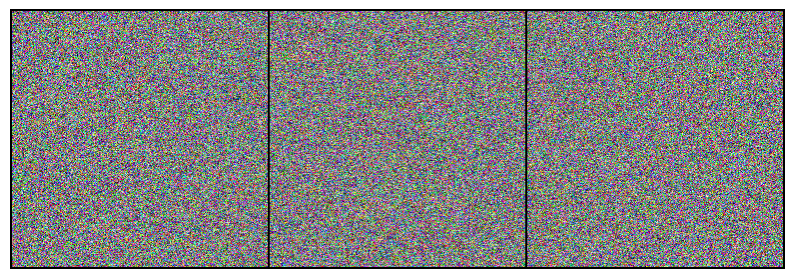

In [84]:
import matplotlib.pyplot as plt # <-- Add this
import torchvision.utils as vutils # <-- Add this
# ... inside cell 3d95dab5 ...
images.shape # (2, 3, 256, 256)

# --- Display the generated images ---
# Move images tensor to CPU and detach from gradient computation
images_cpu = images.cpu().detach()

# If your images are normalized to [-1, 1], denormalize them to [0, 1]
# images_cpu = (images_cpu + 1) / 2 # Uncomment if you used transforms.Normalize(...)

# Clamp values to [0, 1] just in case
images_cpu = torch.clamp(images_cpu, 0, 1)

# Make a grid of images (rows = number of samples)
grid = vutils.make_grid(images_cpu, nrow=len(images_cpu), padding=2, normalize=False) # normalize=False as we clamped

# Convert grid tensor to numpy array and transpose dimensions for matplotlib
# (C, H, W) -> (H, W, C)
np_grid = grid.permute(1, 2, 0).numpy()

# Display the grid
plt.figure(figsize=(10, 5)) # Adjust figure size as needed
plt.imshow(np_grid)
plt.axis('off') # Hide axes
plt.show()
# --- End Display ---